# NOTE THIS IS A SAMPLE.

# THIS USES THE QWEN MODEL TO PREDICT WHETHER OR NOT TEXT IS BOT OR HUMAN GENERATED. THIS IS NOT A PEG APPLICATION; SIMPLY JUST A SAMPLE OF HOW THE BASELINE WILL BE CALCULATED

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import torch.nn.functional as F
import gc
from tqdm import tqdm
import pandas as pd

In [4]:
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [6]:
df = pd.read_csv("./data/all_prompts.csv", index_col = 0)

In [7]:
df.shape

(922584, 3)

In [8]:
sample_size = 100

df_sample = (
    df.groupby("label", group_keys=False)
      .sample(n=sample_size // 2, random_state = 425)
      .reset_index(drop=True)
)

In [9]:
MAX_CHARS = 1200
df_sample["text_truncated"] = df_sample["text"].str.slice(0, MAX_CHARS)

In [10]:
def load_model(model_name):
    """Load one model at a time with 4-bit quantization"""
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        load_in_4bit=True,
        low_cpu_mem_usage=True,
        device_map={"": "cuda"},  # send everything possible to GPU
        llm_int8_enable_fp32_cpu_offload=True  # offload remaining to CPU
    )

    
    return model, tokenizer

In [11]:
def build_prompt(text):
    return f"""
You are a classifier.

Task: Determine if the following text was generated by a bot.

Respond with only 0 (human) or 1 (bot).

Text:
{text}
"""


In [12]:
def get_bot_probs(model, tokenizer, prompt_text):
    input_ids = tokenizer(prompt_text, return_tensors = "pt", truncation = True, max_length = 512).input_ids.to(model.device)
    logits = model(input_ids = input_ids).logits[0, -1]
    
    # Token IDs for "0" (human) and "1" (bot)
    human_token_id = tokenizer("0", add_special_tokens = False).input_ids[0]
    bot_token_id = tokenizer("1", add_special_tokens = False).input_ids[0]
    
    logits_0_1 = logits[[human_token_id, bot_token_id]]
    probs_0_1 = torch.softmax(logits_0_1, dim = 0)
    
    return {"human": probs_0_1[0].item(), "bot": probs_0_1[1].item()}


In [13]:
def get_row_bot_probs(row, model, tokenizer):
    prompt = build_prompt(row["text_truncated"])
    probs = get_bot_probs(model, tokenizer, prompt)
    pred_label = int(probs["bot"] >= 0.5)

    return {"prediction_prob": probs["bot"], "prediction": pred_label}

In [14]:
def infer_bot_probs(df_sample, model_name):
    model, tokenizer = load_model(model_name)
    results = []

    for _, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
        # compute probabilities
        row_result = get_row_bot_probs(row, model, tokenizer)
        results.append(row_result)

        # clean up GPU after each row
        torch.cuda.empty_cache()
        gc.collect()

    return results

In [15]:
results = infer_bot_probs(df_sample, "Qwen/Qwen2-7B-Instruct")

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [25:26<00:00, 15.26s/it]


In [16]:
df_sample["prediction_prob"] = [r["prediction_prob"] for r in results]
df_sample["prediction"] = [r["prediction"] for r in results]

In [17]:
df_sample.to_csv("./Data/Predictions/Baseline/SAMPLE_Qwen2-7B-Instruct_preds.csv")

In [18]:
df_sample

,text,source,label,text_truncated,prediction_prob,prediction
0,Project Monitoring and Control and Risk Assess...,Human,0,Project Monitoring and Control and Risk Assess...,0.503906,1
1,"Dear Principal,\n\nI do not like the idea of n...",Human,0,"Dear Principal,\n\nI do not like the idea of n...",0.091370,0
2,What happened to the Mineos I remember? The sa...,Human,0,What happened to the Mineos I remember? The sa...,0.762207,1
3,Jay wondered what her boyfriend had bought her...,Human,0,Jay wondered what her boyfriend had bought her...,0.354004,0
4,Please tell us how you have spent the last two...,Human,0,Please tell us how you have spent the last two...,0.451416,0
...,...,...,...,...,...,...
95,By understanding the connections between diffe...,unknown,1,By understanding the connections between diffe...,0.592773,1
96,"The atomic bomb, which is a weapon of mass des...",Nous-Hermes-LLaMA-2-13B,1,"The atomic bomb, which is a weapon of mass des...",0.515625,1
97,The role of citizen journalism in the informat...,GPT-3.5,1,The role of citizen journalism in the informat...,0.482422,0
98,Existing works on control of tractor-trailers ...,Flan-T5-XXL,1,Existing works on control of tractor-trailers ...,0.827637,1


In [88]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, classification_report

In [92]:
y_true = df_sample["label"]
y_pred = df_sample["prediction"]

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")

roc_auc = roc_auc_score(y_true, df_sample["prediction_prob"])
print(f"ROC-AUC: {roc_auc}")

f1 = f1_score(y_true, y_pred)
print(f"F1 Score (Bot class): {f1}")

Accuracy: 0.59
ROC-AUC: 0.6538
F1 Score (Bot class): 0.6611570247933884


<Axes: >

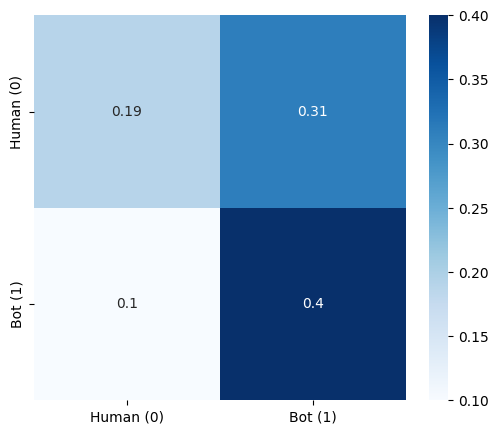

In [74]:
cm = confusion_matrix(y_true, y_pred, normalize = "all")
plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    cmap="Blues",
    xticklabels=["Human (0)", "Bot (1)"],
    yticklabels=["Human (0)", "Bot (1)"]
)